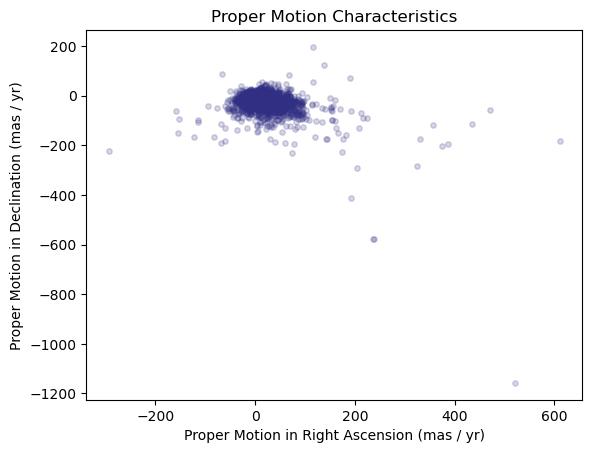

In [3]:
"""
Exerise 4 Full Code

Created on Sat March 15 2025

@author: Sarah Straw


"""

#=================================================================================================================
# Imports
#

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import gaussian_kde


#=================================================================================================================
# Main Code
#

# Part 1: Reading and filtering the data
# a)

DataFile = open('m45-clean.csv','r')

df = pd.read_csv('m45-clean.csv')

# b)

pmra = df['pmra'] # extracting Proper Motion in Right Ascension column from data
pmdec = df['pmdec'] # extracting Proper Motion in Declination column from data

plt.scatter(pmra, pmdec, s=15, c = '#312f84', alpha = 0.2)
plt.xlabel("Proper Motion in Right Ascension (mas / yr)")
plt.ylabel("Proper Motion in Declination (mas / yr)")
plt.title("Proper Motion Characteristics")

plt.savefig('Proper Motion Characteristics.pdf') # saving as pfd to put in report
plt.show()
plt.close()

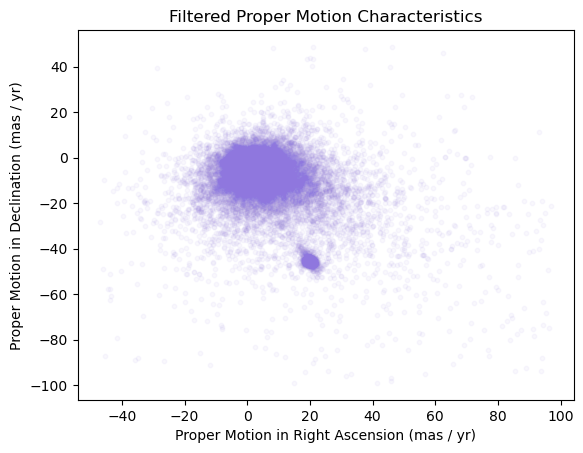

In [4]:
# c)

# each column is put through a condition, returning a Boolean Series.
# these conditions are combined with '&' so only rows which satisfy them all are passed through

DataFrame = df[                                     
    ( df['parallax'] > 0) &                            # postive parallax
    ( df['parallax_error']/df['parallax'] <= 0.2) &    # error in parallax less than 20%
    ( df['pmra'].between(-50, 100) ) &                 # Right Ascension and Declination are reduced to around the clusters
    ( df['pmdec'].between(-100, 50) ) ]

#d)

# scatter plot of filtered data set

plt.scatter(DataFrame['pmra'], DataFrame['pmdec'], s=10, c = '#8f77de', alpha = 0.05) # each point is made very faint to see the clusters 
plt.xlabel("Proper Motion in Right Ascension (mas / yr)")
plt.ylabel("Proper Motion in Declination (mas / yr)")
plt.title("Filtered Proper Motion Characteristics")

plt.savefig('Filtered DataSet Proper Motion Characteristics.pdf') # saving as pfd to put in report
plt.show()
plt.close()

In [5]:
# e)

df_cleaned = DataFrame.dropna() # df_cleaned now has no Nan values 

#
# Part 2: Standardizing
#

scaler = StandardScaler() # using StandardScaler from scikit-learn to standardise data

scaled_data = scaler.fit_transform(df_cleaned)             # finds the mean and standard deviation for each feature and then applies scaling to them
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)  # new data frame with scales features

#
# Part 3: Clustering
#
# a) Clustering techniques: k-means

k_data = df_cleaned[['pmra', 'pmdec']].copy() # for k-means clustering only these columns of the data are needed, using unscaled data

kmeans = KMeans(n_clusters=5, random_state=42) # set the number of clusters to 2

kmeans_labels = kmeans.fit_predict(k_data) # predicts location of clusters

df_cleaned = df_cleaned.assign(KMeans_Cluster=kmeans_labels) # adding a column to df_cleaned with assigned cluster number for each datapoint

In [6]:
# a) Clustering techniques: Gaussian mixture

g_data = df_cleaned[['pmra', 'pmdec']].copy() # same data needed, '.copy' ensures g_data is entirely new data frame

gaus = GaussianMixture(n_components = 5, random_state=42) # only at n_components =5 or higher does the small cluster get recognised

gaus_labels = gaus.fit_predict(g_data) # fitting clustering to the data, assigning each point a label for it's cluster

df_cleaned = df_cleaned.assign(Gaus_Cluster=gaus_labels) # adding a column for gaussian mixture labels

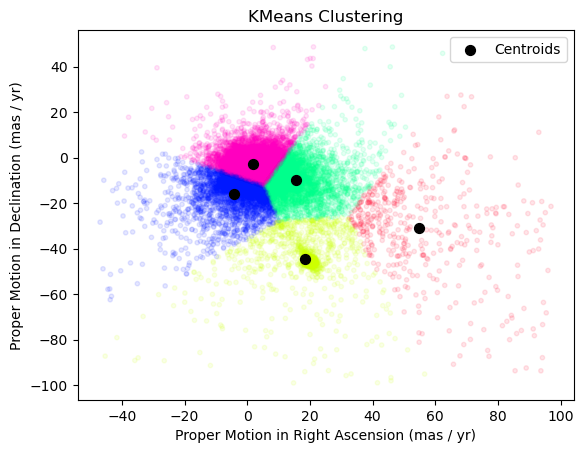

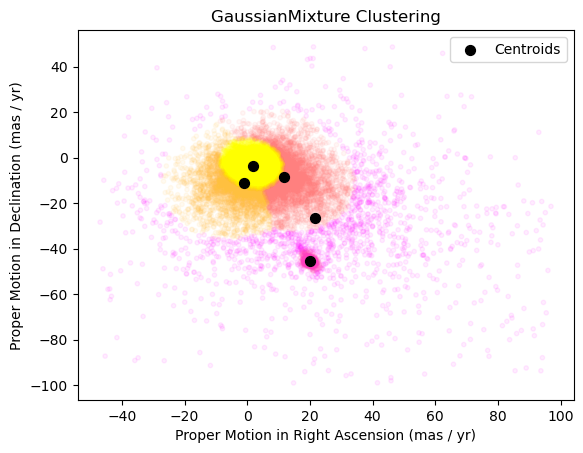

In [7]:
# b) Show the different performance of the two approaches

# K means clustering plot
plt.figure()  # Create another new figure
plt.scatter(k_data['pmra'], k_data['pmdec'], c=kmeans_labels, cmap='gist_rainbow', s=10, alpha = 0.1)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, marker='o', c='black', label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel("Proper Motion in Right Ascension (mas / yr)")
plt.ylabel("Proper Motion in Declination (mas / yr)")
plt.legend()
plt.show()

# gaussian mixture plot
plt.figure()  # Create another new figure
plt.scatter(g_data['pmra'], g_data['pmdec'], c= gaus_labels, cmap = 'spring', s=10, alpha = 0.07)
plt.scatter(gaus.means_[:, 0], gaus.means_[:, 1], s=50, marker='o', c='black', label='Centroids')
plt.title('GaussianMixture Clustering')
plt.xlabel("Proper Motion in Right Ascension (mas / yr)")
plt.ylabel("Proper Motion in Declination (mas / yr)")
plt.legend()
plt.show()

In [8]:
# c) Optimise one of the approaches to extract the interesting sub-group of stars

cluster_data = df_cleaned[ df_cleaned['Gaus_Cluster'] == 1] # filtering the data with condition that that the assigned label = 1 for the small cluster
cluster_data = cluster_data.iloc[:, :-2] # removing the 2 added cluster label columns 

print(f'Stars in small cluster = {cluster_data.shape[0]}')

print(f'Percentage of stars in small cluster = {(cluster_data.shape[0] / 113629)*100 :.2f}%'  )


Stars in small cluster = 1033
Percentage of stars in small cluster = 0.91%


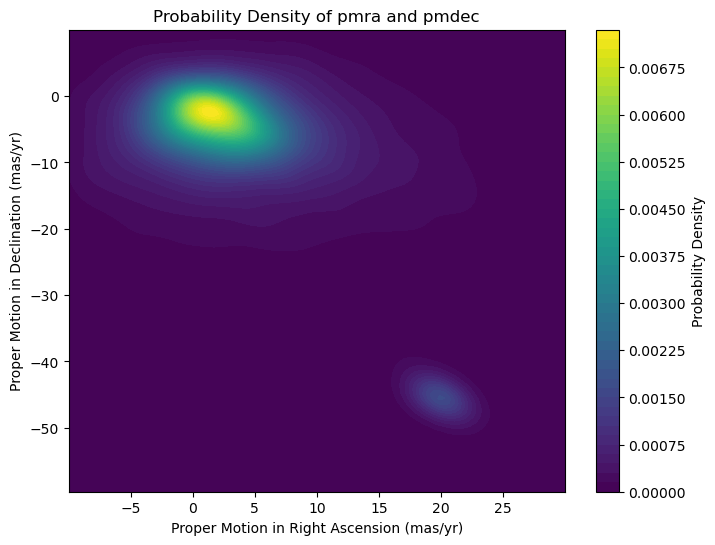

In [9]:
# probability density plot of clusters

df_zoomed = df_cleaned[                  # zooming in on the cluster area                 
    ( df_cleaned['pmra'].between(-10, 30) ) &       
    ( df_cleaned['pmdec'].between(-60, 10) ) ]

prob_data = df_zoomed[['pmra', 'pmdec']] # extracting only needed columns

prob_data_np = prob_data.values.T # converting to numpy array and transposing

kde = gaussian_kde(prob_data_np) # performing Kernel Density Estimation on the data

x_min, x_max = prob_data_np[0].min(), prob_data_np[0].max() # creating a grid for the probability density between min and max probability
y_min, y_max = prob_data_np[1].min(), prob_data_np[1].max()

x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j] # creating grid of 100X100 in which prob density can be evaluated

positions = np.vstack([x.ravel(), y.ravel()]) # flattening 2D arrays x and y into 1D arrays of x and y grid coordinates 

density = np.reshape(kde(positions).T, x.shape) # evaluating density on the grid

plt.figure(figsize=(8, 6)) # plotting the probability density using contourf
plt.contourf(x, y, density, cmap='viridis', levels=50)
plt.colorbar(label='Probability Density')

plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Probability Density of pmra and pmdec')
plt.show()

In [10]:
#
# Part 4: Principal component analysis
#
# a)

# standardising the cluster data
scaler = StandardScaler() # using StandardScaler from scikit-learn to standardise data

cluster_data_scaled = scaler.fit_transform(cluster_data)             # finds the mean and standard deviation for each feature and then applies scaling to them
cluster_data_scaled = pd.DataFrame(cluster_data_scaled, columns=df.columns)  # new data frame with scales features
cluster_data_npary = np.array(cluster_data_scaled) # converting pandas dataframe to a numpy array

# b)

C = np.cov(cluster_data_npary.T) # computing the covarience, transposing so it's covarience between the columns (12) not the rows (1033)

D, V = np.linalg.eig(C) # D holds the eigenvalues and V holds the eigenvectors, np.linalg.eig computes for them for C

ordering = np.argsort(D)[::-1]  # sorting D in descending order
D_ord = D[ordering]
V_ord = V[:, ordering] # reordering eigenvectors to match with descending order eigenvalues

# c) 

PC1 = V_ord[:, 0]  # first principal component
PC2 = V_ord[:, 1]  # second principal component

pca = PCA(n_components=2) # perform PCA with 2 principle components 
pca.fit(cluster_data_npary)

variance_PC1 = ( D_ord[0] / np.sum(D_ord) ) *100 # calculating variance ratio
variance_PC2 = ( D_ord[1] / np.sum(D_ord) ) *100

print(f'Varience due to PC1: {variance_PC1:.2f}% ')
print(f'Varience due to PC2: {variance_PC2:.2f}% ')
print(f'Total Variance due to them both: {(variance_PC1+variance_PC2):.2f}% ')


Varience due to PC1: 27.77% 
Varience due to PC2: 18.99% 
Total Variance due to them both: 46.75% 


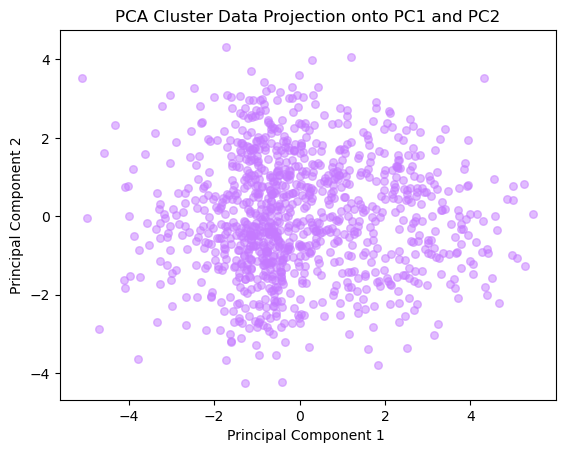

<Figure size 640x480 with 0 Axes>

In [11]:
#
# Part 5: Projection and factor analysis
#
# a)

cluster_data_projected = pca.transform(cluster_data_npary) # projecting the data onto the first 2 principal components

# plotting teh projected data PC1 by PC2 
plt.scatter(cluster_data_projected[:, 0], cluster_data_projected[:, 1], c='#c57aff', alpha=0.5, s=30) 
plt.xlabel('Principal Component 1 ')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Data Projection onto PC1 and PC2')
plt.show()

plt.savefig('PCA Cluster Data Projection onto PC1 and PC2.pdf') # saving as pfd to put in report
plt.show()
plt.close()

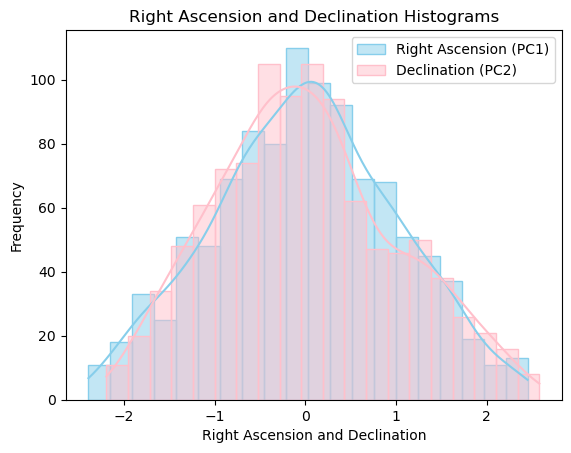

In [97]:
# histograms of RA and Dec to see their variation

ra = cluster_data_npary[:,0] # cluster Right Ascension
dec = cluster_data_npary[:,1] # cluster Declination

ra_min, ra_max = cluster_data_npary[:,0].min(), cluster_data_npary[:,0].max() # max and min values for the bins
d_min, d_max = cluster_data_npary[:,1].min(), cluster_data_npary[:,1].max()

sns.histplot(ra, bins=20, kde=True, color='skyblue',edgecolor='skyblue', alpha = 0.5, label='Right Ascension (PC1)')
sns.histplot(dec, bins=20, kde=True, color='pink', edgecolor='pink', alpha=0.5, label = 'Declination (PC2)') # plotting histogram with seaborn 
plt.title('Right Ascension and Declination Histograms')
plt.xlabel('Right Ascension and Declination')
plt.ylabel('Frequency')
plt.legend()

plt.savefig('histogram.pdf') # saving as pfd to put in report
plt.show()
plt.close()


In [13]:
# b)

V_1_2 = V[:, :2] # only taking the PC1 and PC2 columns of V for the loadings
D_1_2 = D[:2]   # corresponding eigenvalues for PC1 and PC2 

loadings = V_1_2 @ np.diag(np.sqrt(D_1_2)) # matrix multiplication of transposed eigenvector with diagonal matrix of square rooted eigenvalues
# resulting in eigenvector i multiplied with root of eigenvalue i 

loadings_pc1_pc2 = loadings[:, :2] # slicing the first two components, PC1 and PC2

feature_names = df.columns  # feature names
loadings_df = pd.DataFrame(loadings_pc1_pc2, columns=['PC1', 'PC2'], index=feature_names).T # making into a pandas data frame 
loadings_df

,ra,dec,l,b,parallax,pmra,pmdec,g,bp,rp,parallax_error,ruwe
PC1,-0.037109,-0.050311,0.006550,-0.062924,-0.057046,-0.060536,0.051790,0.988730,0.981963,0.990291,0.591678,-0.212449
PC2,0.907285,-0.291608,0.847514,0.383421,-0.167341,-0.660819,0.204771,-0.010772,-0.012890,-0.006259,0.010513,-0.003320


In [14]:
# c)

top_3_values = loadings_df.apply(lambda row: row.nlargest(3), axis=1) # extracting only the top 3 features loadings

print(f"Top three features loadings:")
top_3_values

Top three features loadings:


,b,bp,g,l,ra,rp
PC1,NaN,0.981963,0.98873,NaN,NaN,0.990291
PC2,0.383421,NaN,NaN,0.847514,0.907285,NaN


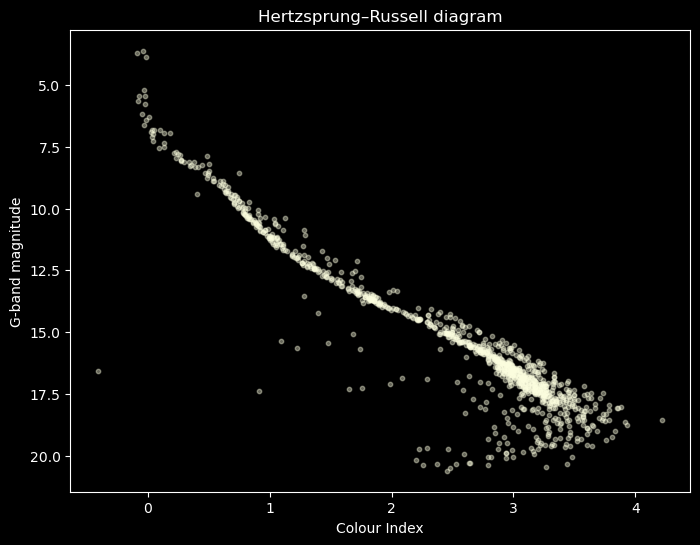

In [101]:
cluster_data.loc[:, "color index"] = cluster_data["bp"] - cluster_data["rp"] # calculate the colour index bp - rp

plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=cluster_data["color index"], y=cluster_data["g"], c = '#49007c', alpha=0.7) # scatter plot using colour index bp - rp for x and g 
plt.scatter(cluster_data["color index"], cluster_data["g"], c = '#fdffe0', s=10, alpha=0.4)
plt.ylabel('G-band magnitude')
plt.xlabel('Colour Index')
plt.title('Hertzsprung–Russell diagram')

plt.gca().invert_yaxis() # invert the y-axis to simulate the Hertzsprung-Russell diagram 

plt.savefig('Hertzsprung–Russell diagram.pdf') # saving as pfd to put in report
plt.show()
plt.close()